In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random


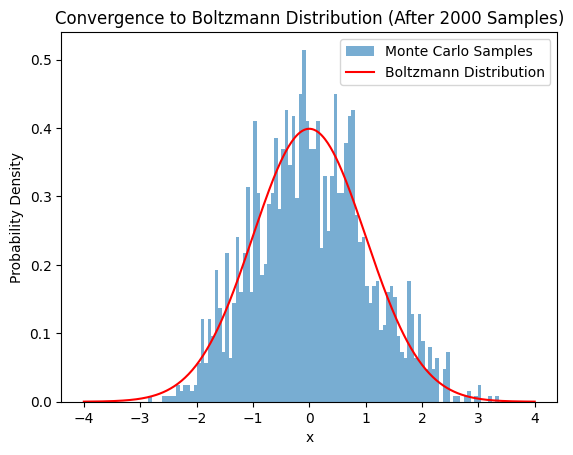

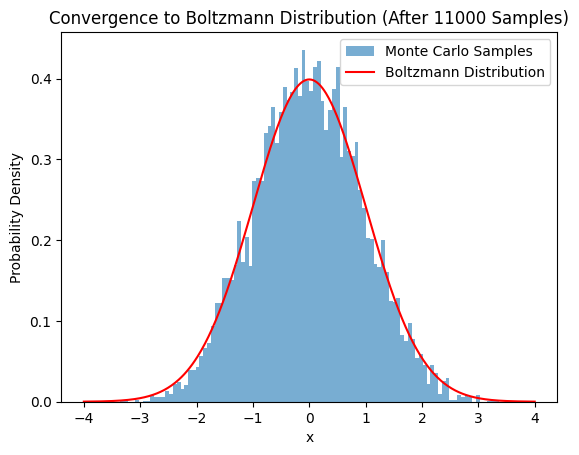

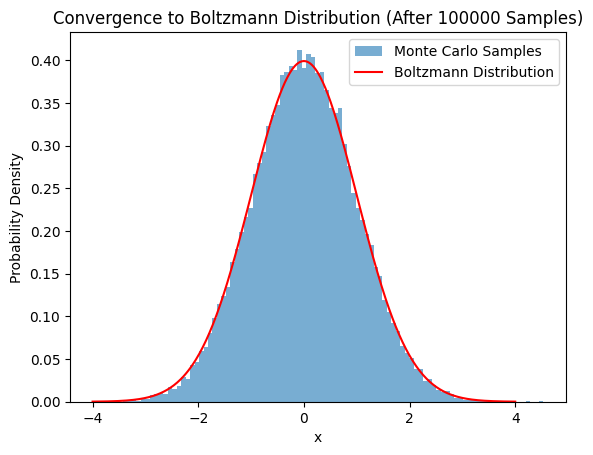

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def energy_function(x):
    """Example energy function: a simple harmonic oscillator."""
    return 0.5 * x**2

def metropolis_sampling(num_samples, beta, x_init=0):
    """Monte Carlo sampling using the Metropolis algorithm."""
    samples = []
    x = x_init

    for _ in range(num_samples):
        # Propose a new state
        x_new = x + np.random.normal(scale=1.0)
        
        # Calculate energy difference
        delta_E = energy_function(x_new) - energy_function(x)

        # Accept or reject the new state
        if np.random.rand() < np.exp(-beta * delta_E):
            x = x_new

        samples.append(x)

    return np.array(samples)

# Parameters
num_samples = 100000
k_B = 1.0
T = 1.0
beta = 1 / (k_B * T)

# Generate samples in chunks to observe convergence
chunk_size = 1000
num_chunks = num_samples // chunk_size
x_vals = np.linspace(-4, 4, 500)
boltzmann_dist = np.exp(-beta * energy_function(x_vals))
boltzmann_dist /= np.trapz(boltzmann_dist, x_vals)  # Normalize

samples = []
for chunk in range(num_chunks):
    new_samples = metropolis_sampling(chunk_size, beta, x_init=(samples[-1] if samples else 0))
    samples.extend(new_samples)

    if chunk in [1, 10, 100, num_chunks - 1]:  # Plot at specific stages
        plt.figure()
        plt.hist(samples, bins=100, density=True, alpha=0.6, label="Monte Carlo Samples")
        plt.plot(x_vals, boltzmann_dist, label="Boltzmann Distribution", color="red")
        plt.title(f"Convergence to Boltzmann Distribution (After {len(samples)} Samples)")
        plt.xlabel("x")
        plt.ylabel("Probability Density")
        plt.legend()
        plt.show()


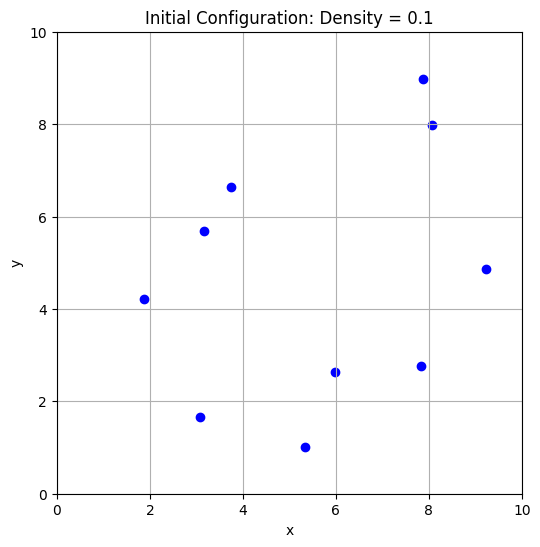

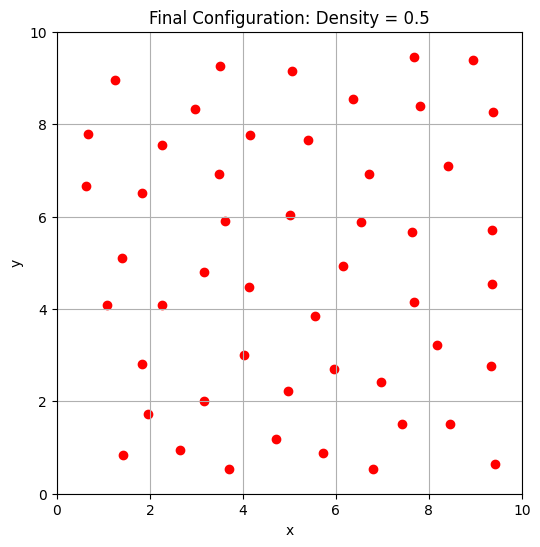

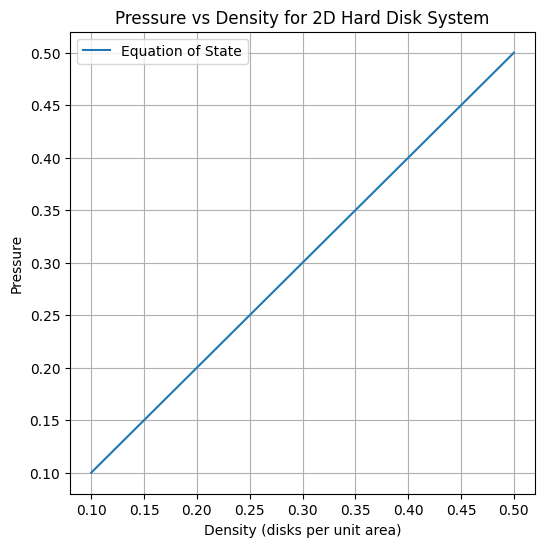

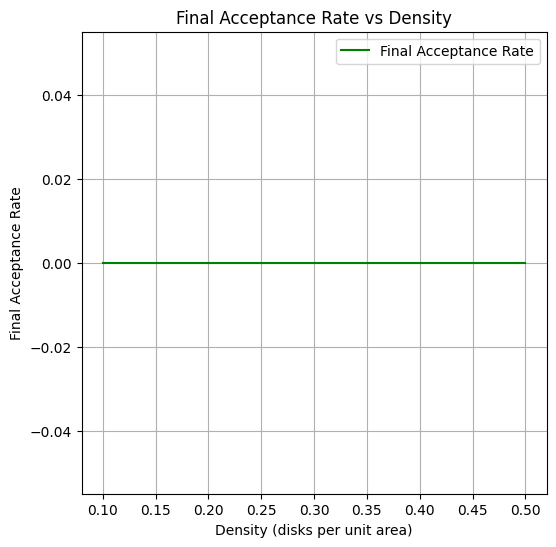

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
area_size = 10.0     # Size of the area (square box)
disk_radius = 0.5    # Radius of the disks
num_steps = 10000    # Number of Monte Carlo steps per run
max_move = 0.1       # Maximum move per step
temperature = 1.0    # Temperature (normalized)
k_B = 1.0            # Boltzmann constant (normalized)
beta = 1.0 / (k_B * temperature)  # Inverse temperature

# Check for overlap between two disks
def check_overlap(disks, new_disk):
    for disk in disks:
        dist = np.sqrt((disk[0] - new_disk[0])**2 + (disk[1] - new_disk[1])**2)
        if dist < 2 * disk_radius:  # Check if the disks overlap
            return True
    return False

# Initialize disks randomly with a given density
def initialize_disks(num_disks, area_size, disk_radius):
    disks = []
    for _ in range(num_disks):
        while True:
            # Randomly place a disk
            x = np.random.uniform(disk_radius, area_size - disk_radius)
            y = np.random.uniform(disk_radius, area_size - disk_radius)
            new_disk = (x, y)
            # Check for overlap with existing disks
            if not check_overlap(disks, new_disk):
                disks.append(new_disk)
                break
    return disks

# Count the number of overlapping pairs
def count_overlap_pairs(disks):
    overlap_count = 0
    for i in range(len(disks)):
        for j in range(i + 1, len(disks)):
            dist = np.sqrt((disks[i][0] - disks[j][0])**2 + (disks[i][1] - disks[j][1])**2)
            if dist < 2 * disk_radius:  # If there's an overlap
                overlap_count += 1
    return overlap_count

# Metropolis algorithm for 2D hard disk system
def metropolis(num_steps, disks, area_size, disk_radius, max_move):
    accepted_moves = 0
    acceptance_rates = []  # List to track acceptance rate at each step
    
    for step in range(num_steps):
        # Choose a random disk to propose a move
        idx = np.random.randint(0, len(disks))
        x, y = disks[idx]
        
        # Propose a new move (small random step)
        new_x = x + np.random.uniform(-max_move, max_move)
        new_y = y + np.random.uniform(-max_move, max_move)
        
        # Ensure the new position is within the area
        new_x = np.clip(new_x, disk_radius, area_size - disk_radius)
        new_y = np.clip(new_y, disk_radius, area_size - disk_radius)
        
        new_disk = (new_x, new_y)
        
        # If there's no overlap, accept the new position
        if not check_overlap(disks, new_disk):
            disks[idx] = new_disk
            accepted_moves += 1
        
        # Calculate and store acceptance rate at each step
        acceptance_rate = accepted_moves / (step + 1)
        acceptance_rates.append(acceptance_rate)
    
    return disks, accepted_moves, acceptance_rates

# Run the simulation and compute equation of state
def equation_of_state(density_range, num_steps, area_size, disk_radius, max_move):
    pressures = []
    acceptance_rates_all = []
    
    for density in density_range:
        num_disks = int(density * area_size ** 2)  # Vary the number of disks based on density
        disks = initialize_disks(num_disks, area_size, disk_radius)
        final_disks, accepted_moves, acceptance_rates = metropolis(num_steps, disks, area_size, disk_radius, max_move)
        
        # Calculate pressure using virial equation
        volume = area_size ** 2  # Area of the system (volume in 2D)
        avg_overlap_count = count_overlap_pairs(final_disks)  # Number of overlap pairs
        
        # Pressure formula for 2D system: P = (N k_B T) / V - (2 * overlap pairs) / V
        pressure = (num_disks * k_B * temperature) / volume - (2 * avg_overlap_count) / volume
        pressures.append(pressure)
        acceptance_rates_all.append(acceptance_rates[-1])  # Store the final acceptance rate
    
        # Plot Initial and Final Configurations only once per density value
        if density == density_range[0]:  # Initial configuration for the first density
            plt.figure(figsize=(6, 6))
            plt.scatter(*zip(*disks), color='blue', label='Disks')
            plt.xlim(0, area_size)
            plt.ylim(0, area_size)
            plt.title(f'Initial Configuration: Density = {density}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.grid(True)
            plt.show()

        if density == density_range[-1]:  # Final configuration for the last density
            plt.figure(figsize=(6, 6))
            plt.scatter(*zip(*final_disks), color='red', label='Disks')
            plt.xlim(0, area_size)
            plt.ylim(0, area_size)
            plt.title(f'Final Configuration: Density = {density}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.grid(True)
            plt.show()
    
    # Plot the Equation of State (Pressure vs Density)
    plt.figure(figsize=(6, 6))
    plt.plot(density_range, pressures, label='Equation of State')
    plt.title('Pressure vs Density for 2D Hard Disk System')
    plt.xlabel('Density (disks per unit area)')
    plt.ylabel('Pressure')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot the final acceptance rate (last value for each density)
    plt.figure(figsize=(6, 6))
    plt.plot(density_range, acceptance_rates_all, label='Final Acceptance Rate', color='green')
    plt.title('Final Acceptance Rate vs Density')
    plt.xlabel('Density (disks per unit area)')
    plt.ylabel('Final Acceptance Rate')
    plt.grid(True)
    plt.legend()
    plt.show()

# Varying density to calculate pressure vs density (Equation of State)
density_range = np.linspace(0.1, 0.5, 5)  # Density range: from low to high
equation_of_state(density_range, num_steps, area_size, disk_radius, max_move)



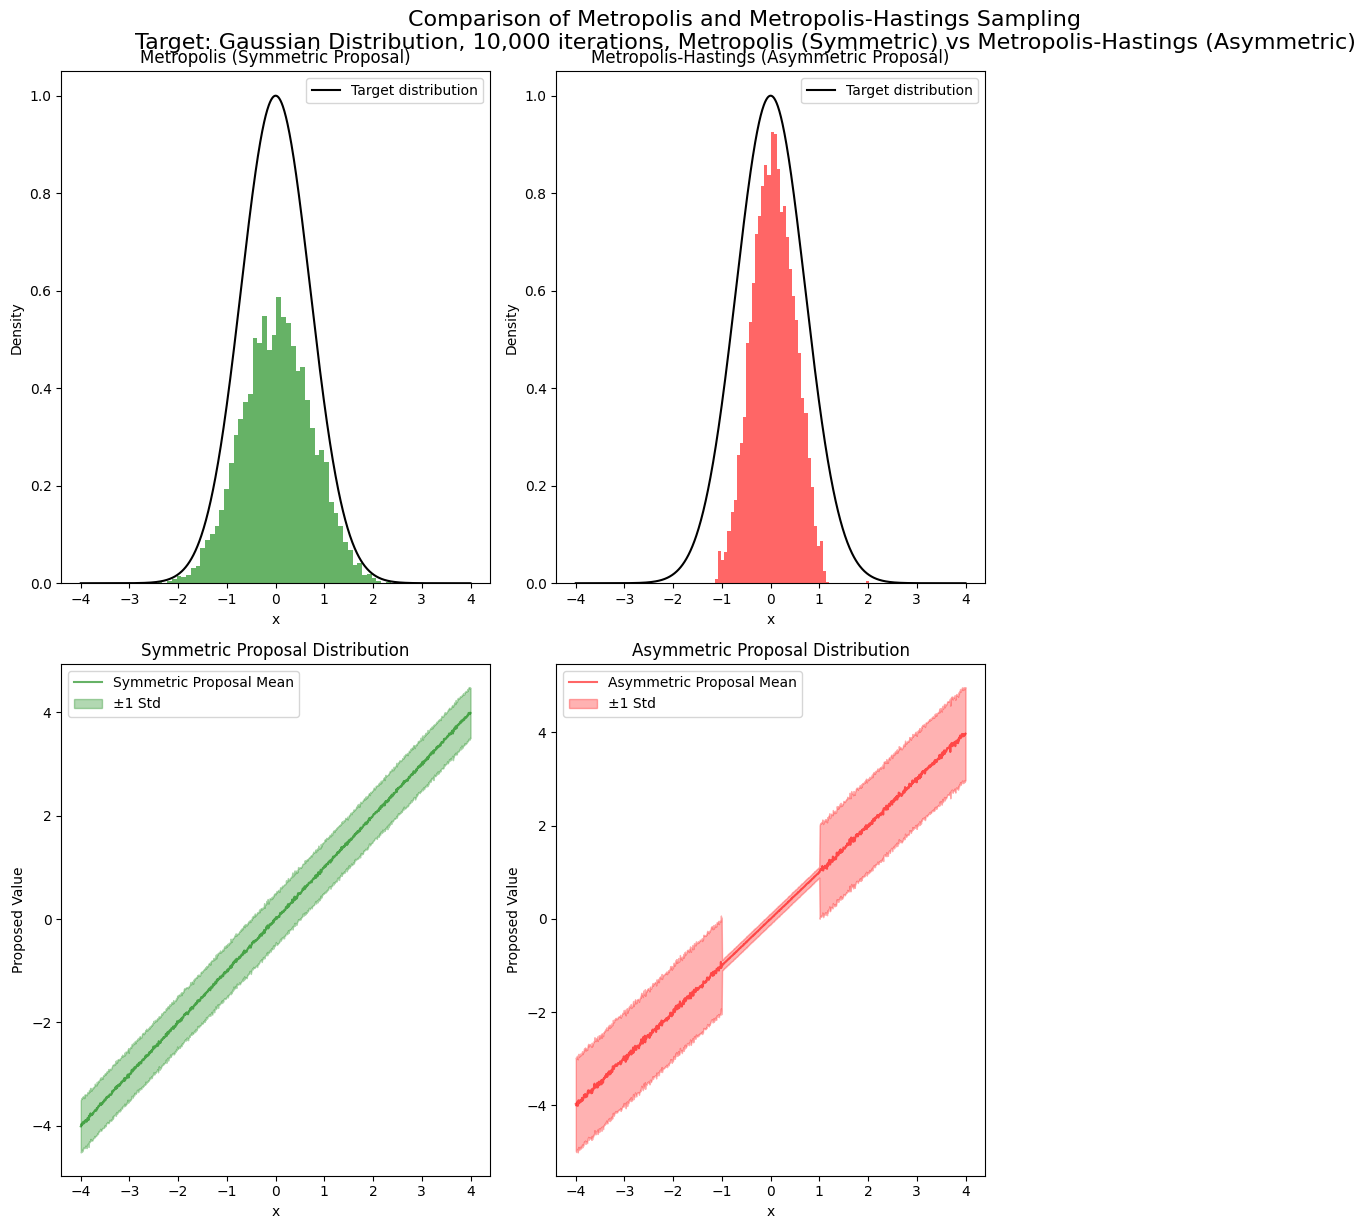

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Target distribution (Gaussian)
def target_distribution(x):
    return np.exp(-x**2)

# Symmetric proposal (Metropolis)
def symmetric_proposal(x):
    return x + np.random.normal(0, 0.5)

def asymmetric_proposal(x):
    if isinstance(x, np.ndarray):  # If x is an array, vectorize
        return np.where(np.abs(x) < 1, x + np.random.uniform(-0.2, 0.2, size=x.shape), 
                         x + np.random.choice([-1, 1], size=x.shape))
    else:  # Otherwise handle as a single scalar
        return x + np.random.uniform(-0.2, 0.2) if np.abs(x) < 1 else x + np.random.choice([-1, 1])

# Metropolis algorithm
def metropolis(n_samples=10000):
    x = 0  # Start at 0
    samples = []
    for _ in range(n_samples):
        x_prime = symmetric_proposal(x)
        accept_prob = min(1, target_distribution(x_prime) / target_distribution(x))
        if np.random.rand() < accept_prob:
            x = x_prime
        samples.append(x)
    return np.array(samples)

# Metropolis-Hastings algorithm
def metropolis_hastings(n_samples=10000):
    x = 0  # Start at 0
    samples = []
    for _ in range(n_samples):
        x_prime = asymmetric_proposal(x)
        accept_prob = min(1, target_distribution(x_prime) / target_distribution(x))
        if np.random.rand() < accept_prob:
            x = x_prime
        samples.append(x)
    return np.array(samples)

# Generate samples
symmetric_samples = metropolis()
asymmetric_samples = metropolis_hastings()

# Plot results
plt.figure(figsize=(15, 12))

# Plot samples and target distribution
x_vals = np.linspace(-4, 4, 1000)

plt.subplot(2, 3, 1)
plt.hist(symmetric_samples, bins=50, density=True, alpha=0.6, color='g')
plt.plot(x_vals, target_distribution(x_vals), 'k-', label="Target distribution")
plt.title("Metropolis (Symmetric Proposal)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(asymmetric_samples, bins=50, density=True, alpha=0.6, color='r')
plt.plot(x_vals, target_distribution(x_vals), 'k-', label="Target distribution")
plt.title("Metropolis-Hastings (Asymmetric Proposal)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()

# Plot proposal distributions
symmetric_means = []
symmetric_stds = []
asymmetric_means = []
asymmetric_stds = []

for x in x_vals:
    symmetric_vals = np.array([symmetric_proposal(x) for _ in range(1000)])
    asymmetric_vals = np.array([asymmetric_proposal(x) for _ in range(1000)])
    
    # Calculate mean and std for each input
    symmetric_means.append(np.mean(symmetric_vals))
    symmetric_stds.append(np.std(symmetric_vals))
    
    asymmetric_means.append(np.mean(asymmetric_vals))
    asymmetric_stds.append(np.std(asymmetric_vals))

# Plot the mean and std for each proposal function
plt.subplot(2, 3, 4)
plt.plot(x_vals, symmetric_means, 'g', alpha=0.6, label="Symmetric Proposal Mean")
plt.fill_between(x_vals, np.array(symmetric_means) - np.array(symmetric_stds), 
                 np.array(symmetric_means) + np.array(symmetric_stds), color='g', alpha=0.3, label="±1 Std")
plt.title("Symmetric Proposal Distribution")
plt.xlabel("x")
plt.ylabel("Proposed Value")
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(x_vals, asymmetric_means, 'r', alpha=0.6, label="Asymmetric Proposal Mean")
plt.fill_between(x_vals, np.array(asymmetric_means) - np.array(asymmetric_stds), 
                 np.array(asymmetric_means) + np.array(asymmetric_stds), color='r', alpha=0.3, label="±1 Std")
plt.title("Asymmetric Proposal Distribution")
plt.xlabel("x")
plt.ylabel("Proposed Value")
plt.legend()

# Add overall title and details
plt.tight_layout()
plt.suptitle("Comparison of Metropolis and Metropolis-Hastings Sampling\n"
             "Target: Gaussian Distribution centered at 0 with std 1\n 10,000 iterations", 
             fontsize=16, y=1.02)

plt.show()



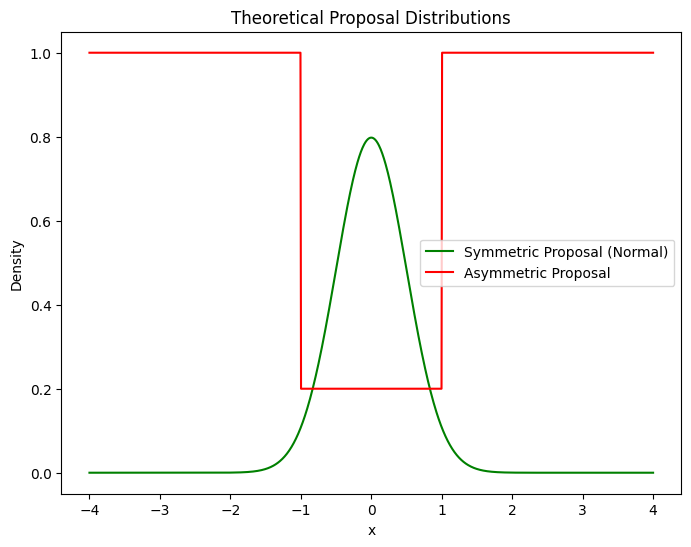

In [34]:
# Theoretical distribution of symmetric proposal (Normal distribution)
def symmetric_theoretical(x):
    return (1/np.sqrt(2 * np.pi * 0.5**2)) * np.exp(-0.5 * (x / 0.5)**2)

# Theoretical distribution of asymmetric proposal
def asymmetric_theoretical(x):
    return np.piecewise(x, [np.abs(x) < 1, np.abs(x) >= 1], 
                        [lambda x: 0.2, lambda x: 1])  # Small step near 0, larger step otherwise

# Plot both distributions on the same chart
plt.figure(figsize=(8, 6))

# Symmetric proposal distribution (Normal)
plt.plot(x_vals, symmetric_theoretical(x_vals), label="Symmetric Proposal (Normal)", color='g')

# Asymmetric proposal distribution
plt.plot(x_vals, asymmetric_theoretical(x_vals), label="Asymmetric Proposal", color='r')

plt.title("Theoretical Proposal Distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()

plt.show()

